In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

from scipy.optimize import minimize
from scipy.stats import linregress

from lightgbm import LGBMRegressor
import lightgbm

from sklearn.ensemble import RandomForestRegressor


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
import keras.backend as K

%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
f = r'C:\Users\mattk\code\Mkt_Data\all_futures.csv'
df = pd.read_csv(f,index_col=0,parse_dates=[0])
df = df.resample('1B').last()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13112 entries, 1970-03-30 to 2020-06-30
Freq: B
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AEX      2790 non-null   float64
 1   AUD      8423 non-null   float64
 2   BOBL     3191 non-null   float64
 3   BTP      2680 non-null   float64
 4   BUND     3513 non-null   float64
 5   CAC      2877 non-null   float64
 6   COPPER   6331 non-null   float64
 7   CORN     12248 non-null  float64
 8   CRUDE_W  7868 non-null   float64
 9   EDOLLAR  9262 non-null   float64
 10  EUR      5328 non-null   float64
 11  EUROSTX  1566 non-null   float64
 12  GAS_US   7560 non-null   float64
 13  GBP      11327 non-null  float64
 14  GOLD     11411 non-null  float64
 15  JPY      10932 non-null  float64
 16  KOSPI    1532 non-null   float64
 17  KR10     1520 non-null   float64
 18  KR3      1515 non-null   float64
 19  LEANHOG  11856 non-null  float64
 20  LIVECOW  12537 non-null  

In [4]:
assets = ['AUD', 'COPPER', 'CORN', 'CRUDE_W',
       'EDOLLAR', 'EUR', 'GAS_US', 'GBP', 'GOLD', 'JPY',
       'LEANHOG', 'LIVECOW', 'MXP', 'NASDAQ',
       'PALLAD', 'PLAT', 'SOYBEAN', 'SP500', 'US10', 'US2',
       'US20', 'US5', 'WHEAT']

In [6]:
df2 = df[assets].loc['1/1/2000':'1/1/2020']

In [36]:
def calc_macd(ser,s=8,l=24):
    '''
    input = series
    
    '''
    x = ser.ewm(span=(2*s-1)).mean() - ser.ewm(span=(2*l-1)).mean()
    y = x/ser.diff().ewm(span=25).std()
    y = y/y.rolling(252).std()
    return y

def momentum(closes):
    x = np.arange(len(closes))
    slope, _, rvalue, _, _ = linregress(x, closes)
    return (((1 + slope) ** 252)-1) * (rvalue ** 2)

def get_feat_ret(asset,df):
    df3 = df.copy(deep=True)
    df3 = df3[[asset]]
    df3.fillna(method = 'ffill',inplace=True)
    df3['dif'] = df3[asset].diff()
    df3.dropna(inplace=True)
    
    tgt_vol = .15/np.sqrt(252)
    
    df3['macd1'] = calc_macd(df3[asset])
    df3['macd2'] = calc_macd(df3[asset],16,48)
    df3['macd3'] = calc_macd(df3[asset],32,96)
    df3['trend1'] = (df3[asset] - df3[asset].shift(1))/(df3[asset].diff().ewm(span=25).std()) # 1d
    df3['trend2'] = (df3[asset] - df3[asset].shift(21))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(21)) # 1m
    df3['trend3'] = (df3[asset] - df3[asset].shift(63))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(63)) # 3m
    df3['trend4'] = (df3[asset] - df3[asset].shift(126))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(126)) # 6m
#     df3['trend5'] = (df3[asset] - df3[asset].shift(252))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(252)) # 1y
    
    #extra features
    df3['mom'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).rolling(60).apply(momentum)

    # df3['scaled_return_next'] = (df3[asset].diff()).shift(-1) # no vol scaling
    df3['scaled_return_next'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).shift(-1)

    df3.dropna(inplace=True)
    
    feat = df3[['macd1','macd2','macd3','trend1','trend2','trend3','trend4','mom']]
    feat = feat.add_prefix(str(asset)+'_')
    ret = df3[['scaled_return_next']]
    
    return feat,ret

In [176]:
# Define rules that generates a forecast from X dataframe

### allow for sliding window features
def data_transform(x_data, num_steps=5):
    """ Changes data to the format for training 
        for sliding window approach """
    # Prepare the list for the transformed data
    X = list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]

        # Append the list with sequencies
        X.append(seq_X)
    # Make final arrays
    x_array = np.array(X)
    return x_array


### direct positions (benchmarks only) ###
def Bench_LS(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    
    out = pd.DataFrame({'position':np.ones(shape=len(xdata))},index=xdata.index)
    
    return out

def Bench_MACD(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    
    out = pd.DataFrame({'position':np.where(((xdata['macd1'] + xdata['macd2'] + xdata['macd3'])/3)>0,1.0,-1.0)},index=xdata.index)
    
    return out

def Bench_Trend(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    
    out = pd.DataFrame({'position':np.where(((xdata['trend1'] + xdata['trend2'] + xdata['trend3'] + xdata['trend4'] + xdata['trend5'])/5)>0,1.0,-1.0)},index=xdata.index)
    
    return out

### Custom Loss ###

def CustomLoss(yTrue,yPred):
    ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
    n = ((yPred - yTrue)**2)*2
    y = (yPred-yTrue)**2
    out = np.where(ix,y,n)
    return np.mean(out)

def obj_function(beta, X, Y):
    pen = 2
    yPred = X.dot(beta)
    ix = np.logical_and((yPred*Y)>0,np.abs(Y)>=np.abs(yPred))
#     resid = (yPred-Y)**2
    resid = np.sqrt((yPred-Y)**2)
    no = resid*pen
    yes = resid
    
    out = np.where(ix,yes,no)
    
    return np.mean(out)
    
def custom_asymmetric_eval(y_true, y_pred):
    penalty = 2.0
    residual = (y_pred - y_true).astype("float")
    ix = np.logical_and((y_pred*y_true)>0,np.abs(y_true)>=np.abs(y_pred))
    loss = np.where(ix, (residual**2), (residual**2)*penalty)
    return "custom_asymmetric_eval", np.mean(loss), False

def custom_asymmetric_objective(y_true, y_pred):
    penalty = 2.0
    resid = (y_pred - y_true).astype("float")
    ix = np.logical_and((y_pred*y_true)>0,np.abs(y_true)>=np.abs(y_pred))
    grad = np.where(ix, 2.0*resid, 2*penalty*resid)
    hess = np.where(ix, 2.0, 2.0*penalty)
    return grad, hess

### Forecasts ### 

def OLS_Forecast(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    lm = LinearRegression()
    lm.fit(xtrain,ytrain)
    preds = lm.predict(xtest)
    
    out = pd.DataFrame(preds,index=xtest.index,columns=[ytrain.columns])
    
    return out

def Linear_Custom(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    newX = np.concatenate((np.ones((xtrain.shape[0],1)), xtrain), axis=1)
#         self.beta_init = np.random.normal(size=(self.X.shape[1]))
    init = np.ones(newX.shape[1])*.1

    result_custom = minimize(obj_function, init, args=(newX,ytrain.to_numpy().ravel()),
              method='BFGS', options={'maxiter': 1000})

    newX = np.concatenate((np.ones((xtest.shape[0],1)), xtest), axis=1)
    out = pd.DataFrame({'forecast':np.matmul(newX,result_custom.x)},index = xtest.index)

    return out
    
def LightGBM(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
#     train_size = int(len(xtrain)*.85)
#     val_size = len(xtrain)-train_size

    #change y's if multiple outputs
#     xtrain2,xval = xtrain.iloc[0:train_size,:], xtrain.iloc[train_size:len(xtrain),:]
#     ytrain2,yval = ytrain.iloc[0:train_size], ytrain.iloc[train_size:len(xdata)]
    
    tss = TimeSeriesSplit(n_splits=5)


    gbm = LGBMRegressor()

    param_grid = {
        "num_leaves": [15,30,50,100],
        "max_depth": [1,2,6,10,15,25],
        "learning_rate" : [0.1,.001,.0001],
        "n_estimators" : [25,50,100,150],
    #     "reg_alpha" : [1,.1,.01,.0001],
    #     "reg_lambda" : [1,.1,.01,.0001],
        }


    rs = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid, 
        cv=tss.split(xtrain),
        n_iter=25,
        n_jobs=-1, 
        scoring='neg_mean_squared_error',
        verbose=0,
        error_score = 'raise'
        )
    rs.fit(xtrain,ytrain)
    preds = rs.predict(xtest)
    print(rs.best_params_)
    
    out = pd.DataFrame({'forecast':preds},index=xtest.index) 
    
    return out

def LightGBM_Custom(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    rs_scorer = make_scorer(CustomLoss,greater_is_better=False)

    tss = TimeSeriesSplit(n_splits=5)


    gbm = LGBMRegressor()
    # gbm.set_params(**{'objective': custom_asymmetric_objective})


    param_grid = {
        "objective": [custom_asymmetric_objective],
        "num_leaves": [15,30,50,100],
        "max_depth": [-1,2,6,10,15,25],
        "learning_rate" : [0.1,.001,.0001],
        "n_estimators" : [25,50,100,150],
    #     "reg_alpha" : [1,.1,.01,.0001],
    #     "reg_lambda" : [1,.1,.01,.0001],
        }


    rs = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid, 
        cv=tss.split(xtrain),
        n_iter=25,
        n_jobs=-1, 
        scoring = rs_scorer,
        verbose=0,
        error_score = 'raise'
        )
    
    
    rs.fit(xtrain,ytrain.squeeze())
#     model.save_model(filepath, num_iteration=model.best_iteration) 
    preds = rs.predict(xtest)
    print(rs.best_params_)
    
    out = pd.DataFrame({'forecast':preds},index=xtest.index) 
    
    return out

def LSTM_Forecast(xtrain,ytrain,xtest,verbose=0,plot=False, save = True):
    
    num_steps = 60

    t_xtrain= data_transform(xtrain.to_numpy(), num_steps = num_steps)
    t_ytrain= data_transform(ytrain.to_numpy(), num_steps = num_steps)
    t_xtest= data_transform(xtest.to_numpy(), num_steps = num_steps)
    
    if save:
        callbacks=[
                  tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)]
    else:
        callbacks=[]
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(t_xtrain.shape[1], t_xtrain.shape[2])),
        tf.keras.layers.LSTM(20,dropout=.3,recurrent_dropout=.3),
        tf.keras.layers.Dense(t_ytrain.shape[2])
    ])
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=.001))
    
    history = model.fit(t_xtrain, t_ytrain, epochs=100 ,verbose=verbose,
                        validation_split=.25, shuffle=True,
                        callbacks=callbacks,
                        batch_size=int(len(t_xtrain)/5))
    
    if plot:
        plt.plot(history.history['loss'],label = 'train')
        plt.plot(history.history['val_loss'],label='val')
        plt.legend()
    
#     joblib.dump(model, filepath)

    m2 = tf.keras.models.load_model(filepath)
    pred = m2.predict(t_xtest)
#     pred  = model.predict(t_xtest)
    
    return pd.DataFrame(pred,index=xtest[num_steps:].index)



### Functions to get positions and stats

def set_position(d,how=1,Tstd = .15):
    '''
    Given an array of forecasts, return position in assets
    
    params:
    ...........
    how:
        1 = binary -1 or 1 based on sign of the forecast
        2 = +1/-1 if forecaste > 1 std of target, 0 otherwise
    '''
    f = d.copy()
    
    if how==1:
        return np.sign(f)
    
    if how==2:
        
        f[(f>-Tstd/np.sqrt(252)) & (f<Tstd/np.sqrt(252))] = 0.0
        f[f>=Tstd/np.sqrt(252)] = 1.0
        f[f<=-Tstd/np.sqrt(252)] = -1.0
        
        return f
    
def get_returns(p,r,how=1):
    assert p.shape == r.shape, 'Data not the same shape!'
    
    rets = p*r
    if how ==1:
        return rets.mean(axis=1)
    else:
        return rets
    
def stats(r,factor=252,verbose = False):
    u = r.mean()*factor
    sig = r.std()*np.sqrt(factor)
    
    
    if verbose:
        print('Return: {}'.format(u))
        print('Vol: {}'.format(sig))
        print('Sharpe: {}'.format(u/sig))
    
    return u, sig, u/sig

In [ ]:
#Generate Predictions

times = [('2000','2003','2004','2007'),
      ('2000','2007','2008','2011'),
      ('2000','2011','2012','2015'),
      ('2000','2015','2016','2019')
     ]

# times = [('2000','2003','2004','2007'),
#       ('2004','2007','2008','2011'),
#       ('2008','2011','2012','2015'),
#       ('2012','2015','2016','2019')
#      ]


port=[]


models=[
#     OLS_Forecast,
#     LSTM_Forecast,
    LightGBM_Custom,
       ]

for m in models:
    group=[]
    print(str(m))

    for asset in assets:
        print(asset)
        pfull = []
        
        d = get_feat_ret(asset,df2)
        xdata = d[0].copy()
        ydata = d[1].copy()
        
        for ts1,ts2,tr1,tr2 in times:
            print('--------------')
            print(ts1,ts2,tr1,tr2)
            print('--------------')
            
            xtrain,xtest = xdata[ts1:ts2], xdata[tr1:tr2]
            ytrain,ytest = ydata[ts1:ts2], ydata[tr1:tr2]

            scalerX = StandardScaler()

            xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
            xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)
            
            ##### Not standard, just normalize
            xtrain_sc = xtrain/xtrain.std()
            xtest_sc = xtest/xtrain.std()
            
            #####
            
            filepath="../results/"+str(m.__name__) + "-" + str(asset) + "-" + str(tr1) + "-" + str(tr2) + "-used.hdf5"
            
            pred = m(xtrain_sc,ytrain,xtest_sc)
            pred.columns = [asset]
#             pfull.append(np.sign(pred))
            pfull.append(pred)
            
        group.append(pd.concat(pfull))
        
    f = "../results/Test_" + str(m.__name__) + "_forecast"
    pd.concat(group,axis=1).to_pickle(f)
    
    port.append((str(m.__name__),pd.concat(group,axis=1)))

<function LightGBM_Custom at 0x00000147701505E0>
AUD
--------------
2000 2003 2004 2007
--------------
{'objective': <function custom_asymmetric_objective at 0x00000147701503A0>, 'num_leaves': 15, 'n_estimators': 150, 'max_depth': -1, 'learning_rate': 0.0001}
--------------
2000 2007 2008 2011
--------------


In [ ]:
# Convert predictions to positions + Stats

models=[
    OLS_Forecast,
#     LSTM_Forecast,
    LightGBM_Custom,
       ]


all_returns = pd.read_pickle("../results/actual_returns")

for m in models:
    print(m.__name__)
    read = "../results/Test_" + str(m.__name__) + "_forecast"
#     read = "../results/best_predictions/Best_" + str(m.__name__) + "_forecast"

    forecast = pd.read_pickle(read)
    position = set_position(forecast,how=1)
    returns = position.mul(all_returns.loc[position.index,:]).mean(axis=1)
    stats(returns,verbose=True)
    print('--------')

In [ ]:
Test_OLS_Forecast_forecast

In [223]:
models=[
    OLS_Forecast,
#     LSTM_Forecast,
    LightGBM_Custom,
       ]

for m in models:
    print(str(m.__name__))

OLS_Forecast
LightGBM_Custom


In [249]:

read = "../results/best_predictions/Best_" + "LSTM_Forecast" + "_positions"
position = pd.read_pickle(read)
# position = set_position(forecast,how=1)
returns = position.mul(all_returns.loc[position.index,:]).mean(axis=1)
stats(returns,verbose=True)

Return: 0.00661451805745408
Vol: 0.03042828425255371
Sharpe: 0.2173805792845173


(0.00661451805745408, 0.03042828425255371, 0.2173805792845173)

0.25630123719902437


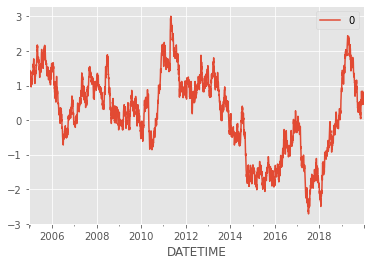

In [219]:
for i in range(len(port)):
    p = np.sign(port[i][1])
    r = p.mul(all_returns.loc[p.index,:].values).mean(axis=1)
    (r.rolling(252).mean()*np.sqrt(252)/r.rolling(252).std()).dropna().plot(label=i)
    print(r.mean()*np.sqrt(252)/r.std())
    
    plt.legend()

1.0118219386172909


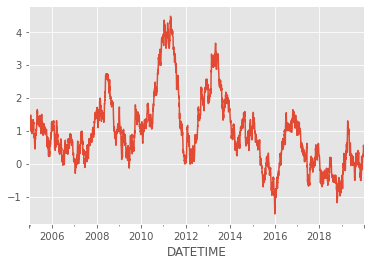

In [147]:
grouped = pd.concat(np.array(port)[:,1])
grouped = grouped.groupby(grouped.index).mean()
r = grouped.mul(returns.loc[grouped.index,:].values).mean(axis=1)
(r.rolling(252).mean()*np.sqrt(252)/r.rolling(252).std()).dropna().plot()
print(r.mean()*np.sqrt(252)/r.std())

In [152]:
np.array(port)[:,0]

array(['OLS_Forecast', 'LSTM_Forecast', 'LightGBM_Custom'], dtype=object)

In [85]:
p = port[1][1]
r = p.mul(returns.loc[p.index,:].values) 
(((r.rolling(252).mean()*np.sqrt(252))/(r.rolling(252).std())).dropna()).describe().T

,count,mean,std,min,25%,50%,75%,max
AUD,3683.0,0.207007,0.927198,-2.220809,-0.348548,0.273413,0.821857,2.889434
COPPER,3683.0,0.241061,1.108416,-2.099356,-0.503692,0.104977,0.994177,3.602123
CORN,3683.0,-0.194457,0.777493,-2.600316,-0.700444,-0.290378,0.354156,1.976207
CRUDE_W,3683.0,-0.270489,1.095175,-3.402549,-0.960176,-0.004623,0.557752,1.810197
EDOLLAR,3683.0,0.221468,0.983295,-2.013135,-0.516867,0.098602,0.929596,2.758983
EUR,3683.0,0.176377,0.972421,-1.792946,-0.687532,0.175365,1.014440,2.492578
GAS_US,3683.0,-0.306931,0.912973,-2.879391,-1.022852,-0.236617,0.400948,1.961470
GBP,3683.0,0.567986,1.061797,-2.113902,-0.232042,0.443064,1.359804,3.083666
GOLD,3683.0,-0.173532,0.976772,-2.287212,-0.866053,-0.206302,0.528215,2.784428
JPY,3683.0,0.171719,0.798698,-2.088786,-0.390003,0.210689,0.711139,2.073745


1. Individual OLS mse forecasts, binary position: 0.9144850945403715
2. Individual lighgbm custom forecasts, binary position: 0.5668860809840637
3. Individual LSTM custom asymmetric forecast, binary position: 0.7271008795964911
---
4. Portfolio mse Random Forest forecast, binary positions
5. Portfolio Linear Sortino Positions
6. Portfolio LSTM Sortino Positions
---
7. Equal Weight Combination
8. Custom Combination

In [240]:
d[0].describe()

,WHEAT_macd1,WHEAT_macd2,WHEAT_macd3,WHEAT_trend1,WHEAT_trend2,WHEAT_trend3,WHEAT_trend4,WHEAT_mom
count,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4.963000e+03
mean,-0.205705,-0.339551,-0.642391,-0.004473,-0.083175,-0.157736,-0.212965,2.971238e-05
std,1.186681,1.416644,1.938891,0.962564,1.005435,0.977869,1.035612,1.124096e-03
min,-4.192712,-4.190007,-5.735619,-3.078434,-3.611899,-3.360540,-5.095142,-7.120967e-03
25%,-1.031484,-1.334550,-1.807677,-0.658880,-0.761332,-0.758431,-0.880032,-1.145697e-04
50%,-0.254247,-0.453807,-0.937315,0.000000,-0.111063,-0.146095,-0.237828,-6.401437e-11
75%,0.585126,0.576623,0.755473,0.616669,0.605258,0.448131,0.425782,1.128873e-04
max,3.488488,3.785137,5.638283,3.154206,3.437322,3.494083,2.970151,1.565925e-02


In [238]:
(d[0]/d[0].std()).describe()

,WHEAT_macd1,WHEAT_macd2,WHEAT_macd3,WHEAT_trend1,WHEAT_trend2,WHEAT_trend3,WHEAT_trend4,WHEAT_mom
count,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4.963000e+03
mean,-0.173345,-0.239687,-0.331319,-0.004647,-0.082725,-0.161305,-0.205641,2.643224e-02
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
min,-3.533143,-2.957698,-2.958196,-3.198160,-3.592374,-3.436594,-4.919931,-6.334839e+00
25%,-0.869218,-0.942050,-0.932325,-0.684506,-0.757216,-0.775595,-0.849769,-1.019217e-01
50%,-0.214251,-0.320340,-0.483429,0.000000,-0.110463,-0.149401,-0.229650,-5.694743e-08
75%,0.493078,0.407035,0.389642,0.640652,0.601986,0.458273,0.411140,1.004250e-01
max,2.939703,2.671904,2.907994,3.276880,3.418741,3.573159,2.868014,1.393052e+01
